# Introducción

El objetivo de este estudio es identificar si una sesión TCP va cifrada o no. En la fase de entrenamiento se usan los paquetes, ya que la caracterización es mucho más afinada que cuando se realiza el entrenamiento por sesion.

A la hora de dar una respuesta de si una sesión está cifrada o no, se recogen los siguientes valores:

- Vector 1: clasificación del paquete dentro de una sesión. Que será -1 en los paquetes no cifrados y 1 en los cifrados 
        
- Vector 2: tamaño de cada paquete dentro de una sesión

Se suma el producto de ambos vectores y el resultado se normaliza con una tangente hiperbólica. 
El resultado final de la sesión estará entre -1 y 1.

En este documento se detalla la fase de entrenamiento. 

# Datos de entrenamiento

Los datos de entrenamiento se componen de una muestra de tráfico de un eficio de Servicios Centrales de BBVA. Éstos se tienen en forma de fichero PCAP, que ocupa más de 4 GB. Sin embargo, la diferencia de tiempo entre el primer y el último paquete es de 1,5 segundos, por lo que se utiliza también algún PCAP de la web de Wireshark.

## Descripción

En esta fase utilizan paquetes que usan distintos protocolos. Para filtrarlos, se usan filtros de Wireshark (también aplicables a TShark, en caso de querer automatizar el proceso). Los protocolos que se usan para el entrenamiento son los siguientes: 

- **TELNET**: no cifrado
- **SMB**: cifrado
- **SSH**: cifrado
- **SSL**: cifrado
- **HTTP**: no cifrado 

## Filtros de Wireshark

Con el objetivo de poder reproducir este estudio, se proporcionan los filtros que se aplicaron para conseguir los datos de entrenamiento

- **TELNET**: telnet.data
- **SMB3**: smb2.ses_flags.encrypt
- **SSH**: ssh.encrypted_packet
- **SSL**: ssl and not ssl.handshake
- **HTTP**: http and not http2 and not ssl  and not (tcp.srcport == 8080 or  tcp.srcport == 80 )

Sobre el protocolo http se aplican más filtros a la hora de crear el dataset, ya que también existen paquetes que pueden estar cifrados, aunque no salgan con el protocolo *SSL* en wireshark

In [43]:
import math
import numpy as np
import pandas as pd
from sklearn.externals import joblib
import seaborn as sns; sns.set()
from scipy import stats
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
import packet_processing
import seaborn as sns
err_level = np.seterr(divide='ignore', invalid='ignore')

# Variables utilizadas
## Contraste chi-cuadrado de Pearson sobre toda la distribución
Esta prueba mide la discrepancia entre una distribución observada y una distribución uniforme, que sería la distribución teórica en caso de que los datos estuvieran cifrados.

Cuanto mayor sea el valor de chi-cuadrado, menos verosímil es que siga una distribución uniforme (que la hipótesis nula sea correcta). De la misma forma, cuanto más se aproxima a cero el valor de chi-cuadrado, más ajustadas están ambas distribuciones.


In [44]:
def pearsonchisquare(observed):
    expected = sum(observed) / 256
    return sum((observed - expected)**2 / expected)

También se realiza un contraste de hipótesis, pero en vez de usar la distribución uniforme se usa una distribución típica de una sesión SMB3. Esta variable no se usa en el modelo, sino en el proceso de etiquetado. 

In [118]:
def pearsonchisquareSmb(input,expected):
    try:
        size = sum(input)
        observed = input / size
        res = sum(np.divide((observed - expected)**2,expected,where=expected!=0))
    except Exception as e: 
        print("error en chismb: " + str(e))
        res = 10000
    return res

## Entropía de Shannon sobre toda la distribución
La entropía mide el grado de incertidumbre o de homogeneidad en la información. Dado que una distribución uniforme es homogénea, la entropía es una característica importante para determinar si unos datos están cifrados. 

In [119]:
def entropy(observed):
    observed = np.trim_zeros(np.sort(observed))
    sz = sum(observed)
    p = observed / sz
    ent = -sum(p * np.log(p) / math.log(256))
    return ent * 8


## Entropía de Shannon sobre parte de la distribución 
Esta variable mide lo mismo que la anterior, pero elimina las siguientes posiciones:

- Primera
- Segunda
- Última
- Moda (valor más repetido una vez eliminados los citados anteriormente)

La razón por la que existe esta variable es que las herramientas de parseo de pcaps no tienen implementados ciertos protocolos de la capa de aplicación y lee las cabeceras de los mismos como si fuera el payload. Esto causa que hayan picos en paquetes cifrados que hace que la entropía disminuya pese a estar cifrado el payload.

In [120]:
def entropy_cut(observed):
    try: 
        observed = np.trim_zeros(np.sort(observed))
        sz = sum(observed)
        p = observed / sz
        ent = -sum(p * np.log(p) / math.log(len(observed)+1))
        res = ent * 8
    except:
        res = 0
    if not res >= -0.01:
        res = 0
    return res

## Moda
La moda es el byte más repetido. En ocasiones, puede servir para caracterizar el protocolo.


In [121]:
def calculate_mode(observed):
    return np.where(observed ==np.max(observed))[0][0]

## Variedad
La variedad cuenta cuantos bytes hay en la distribución que no sean cero.

In [122]:
def calculate_variety(observed):
    return len(observed[observed!=0])

## Dispersion
La dispersión mide el ancho de la distribución, teniendo en cuenta los ceros.

In [123]:
def calculate_dispersion(observed):
    return len(observed) 

## Most_ASCII
Determinados bytes pertenecen a la tabla ASCII imprimible. Si se utilizan estos más que el resto, puede indicar que los datos no están cifrados.

In [124]:
def calculate_most_ascii(observed, observed2):
    ascii_char = observed[31:127].sum()  + observed[10:14].sum()
    return ascii_char/(observed2.sum()+1)


## Non_printable
Se ha observado que algunos bytes dentro de la distribución aparecen con frecuencia en los datos cifrados. 
La variable non_printable representa la proporción de bytes no imprimibles con respecto al resto de bytes que contiene el payload del paquete

In [134]:
def calculate_non_printable(observed, observed2):
    docx_char = observed[190:250].sum()
    return docx_char/(observed2.sum()+1)

## Media
Se calcula la media para detectar sesgos en la distribución.

In [135]:
def calculate_mean (paqs):
    return np.mean(paqs)

# Funciones para la creación del dataset

In [136]:
def separate_variables(df_o):
    try:
        df = df_o.copy()
        y = df["label"]
        del df["label"]
    except:
        y=[]
        print("no se pueden separar las variables")
        pass
    return y, df

In [137]:
def preprocess_all_X_and_train(df):
    df["chi2"] = (df["chi2"]+1).apply( np.log)
    df["mode"] = (df["mode"]+1).apply( np.log)
    df["most_ascii"] = (df["most_ascii"]+1).apply( np.log)
    df["entropy_cut"] = (df["entropy_cut"]).apply( np.exp)
    x = df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    joblib.dump(min_max_scaler, 'min_max_scaler.pkl') 
    cols = df.columns 
    ind = df.index
    df = pd.DataFrame(x_scaled, columns = cols, index= ind)
    return df

In [138]:
def train_model_gnb(X,y):
    gnb = GaussianNB()
    gnb.fit(X, y)
    joblib.dump(gnb, 'naive_bayes_model.pkl') 


In [139]:
def load_model_gnb():
    gnb = joblib.load('naive_bayes_model.pkl') 
    return gnb


In [149]:
def draw_distributions(X,y):
    %matplotlib inline
    df_plot = pd.DataFrame()
    df_plot = X.copy()
    df_plot["label"] = y.values
    sns.pairplot(df_plot, hue="label",  size=3);
    plt.savefig('distribution.png', dpi = 200) 

In [141]:
def draw_distributions_pred(X,y):
    %matplotlib inline
    df_plot = pd.DataFrame()
    df_plot = X.copy()
    df_plot["label"] = y
    sns.pairplot(df_plot, hue="label",  size=5);


In [142]:
def boxplot_encr(X1,y):
    X = X1.copy()
    X["y"] = y
    encr = X[(X["y"] == 1)]
    encr_y = encr["y"]
    del encr["y"]
    encr.boxplot(rot=50,figsize=(20,8));plt.title('Paquetes cifrados');plt.show()

In [143]:
def boxplot_non_encr(X1,y):
    X = X1.copy()
    X["y"] = y
    non_encr = X[X["y"] == -1]
    non_encr_y = non_encr["y"]
    del non_encr["y"]
    non_encr.boxplot(rot=50,figsize=(20,8));plt.title('Paquetes no cifrados');plt.show()

In [150]:
def violin_plot(X1,y,variable):
    X = X1.copy()
    X["y"] = y
    ax = sns.violinplot(x="y", y=variable, data=X)
    plt.savefig(variable + '.png', dpi = 200) 

Funciones que crean el dataset con las variables más relevantes.

In [145]:
def create_variables(obs1, paqs, session_stats, label, filt):
    obs = np.bincount(paqs,minlength =256)
    mode = np.where(obs ==np.max(obs))[0][0]
    try:
        obs2 = obs[1:]
        obs2 = obs2[1:]
        obs2 = obs2[:-1]
        mode2 = np.where(obs2 ==np.max(obs2))[0][0]
        obs2 = np.delete(obs2, mode2)
    except:
        pass
    chi2 = pearsonchisquare(obs)
    chi2_cut = pearsonchisquare_cut(obs2)
    ent = entropy(obs)
    ent_cut = entropy_cut(obs2)
    variety = calculate_variety(obs)
    dispersion = calculate_dispersion(obs1)
    most_ascii = calculate_most_ascii(obs, obs2)
    non_printable = calculate_non_printable(obs, obs2)
    mean = calculate_mean (paqs)
    session_stats["entropy"] = [ent]
    session_stats["most_ascii"] = [most_ascii]
    session_stats["non_printable"] = [non_printable]
    session_stats["entropy_cut"] = [ent_cut]
    session_stats["chi2"] = [chi2]
    session_stats["mode"] = mode
    session_stats["dispersion"] = [dispersion]
    session_stats["mean"] = [mean]
    session_stats["variety"] = [variety]
    session_stats["label"] = [label]
    if filt: 
        expected =np.genfromtxt('expectedSMB.csv', delimiter=',')
        chi2_smb = pearsonchisquareSmb(obs, expected)
        if chi2_smb<4 and dispersion >= 250:
            session_stats["label"] = [1]
 
    return session_stats

In [107]:
def  create_dataset(i, df, pkts, label, filt ):
    all_paquets = list()
    all_paquets = iteration(pkts)
    for paquete in all_paquets:
        all_paquets = list()
        session_stats = {}
        session_stats["sessionID"] = i
        session_stats["entropy"] = 0
        session_stats["entropy_cut"] = 0
        session_stats["mode"] = 0
        session_stats["dispersion"] = 0
        session_stats["chi2"] = 0
        session_stats["variety"] = 0 
        session_stats["mean"] = 0
        session_stats["most_ascii"] = 0
        size = 0
        n_paqs = 0
        sesion_no_cifrada = False
        paqs = process_packet_TCP(paquete)
        if (len(paqs)!= 0 ):
            paqs = paqs.astype(np.int64)
            obs1 = np.bincount(paqs)
            if len(obs1) > 1 and paqs.sum()!= 0:
                create_variables(obs1, paqs, session_stats, label, filt)
                tmp_df = pd.DataFrame(session_stats)
                tmp_df = tmp_df.set_index("sessionID")
                df = df.append(tmp_df)

        i += 1
    return df, i


## Creación del dataset 

Se construye el dataset para entrenamiento. Se etiqueta en función de los PCAPS utilizados. Para parsear los pcaps se utiliza la librería Scapy.

In [108]:
import imp
imp.reload(packet_processing)
from packet_processing import * 


In [109]:
df = pd.DataFrame()
path = "/data/pcaps/"
pcap_names = ["smb_enc.pcap","http_plain_train_3.pcap","ssl_train_2.pcap",\
              "port_8181_train.pcap", "ssh_train.pcap",  "telnet-raw.pcap"]
labels = [1, -1, 1, -1, 1, -1]
i=0
special_filtering = [0, 1, 0, 0, 0, 0]
if len(pcap_names) == len(labels) and len(labels) == len(special_filtering):
    for n in range(len(pcap_names)):
        file = read_file(path + pcap_names[n])
        df, i = create_dataset(i, df, file,  labels[n] , special_filtering[n])
else:
    print(len(pcap_names), len(labels), len(special_filtering) )

Se deben separar las variables independientes de la dependiente. Luego hay que normalizar las variables independientes y realizar transformaciones logarítmicas y exponenciales en algunas variables.

In [110]:
y, X = separate_variables(df)
X = preprocess_all_X_and_train(X)

# Análisis de las variables del dataset 
Una vez se ha creado y normalizado el dataset, se procede a analizar las variables. Abajo se muestran las primeras filas del mismo.


In [111]:
X.head()

,chi2,dispersion,entropy,entropy_cut,mean,mode,most_ascii,non_printable,variety
sessionID,,,,,,,,,
0,0.317618,1.0,0.780260,0.762706,0.345354,0.0,0.068402,0.151515,0.474510
1,0.313139,1.0,0.786327,0.774507,0.353230,0.0,0.067814,0.145000,0.490196
2,0.309995,1.0,0.798668,0.781563,0.361722,0.0,0.065124,0.144279,0.529412
3,0.319210,1.0,0.778003,0.755982,0.352355,0.0,0.062698,0.126263,0.474510
4,0.308529,1.0,0.796800,0.809888,0.340845,0.0,0.070682,0.149254,0.509804


## Análisis general

En términos generales, se muestran gráficos en los que se aprecia la diferente caracterización que aportan las variables a los paquetes cifrados y a los no cifrados, pudienso así modelar su comportamiento. 

En este caso, por ejemplo, a simple vista se observa una clara diferencia entre los paquetes cifrados y los que no lo están. 


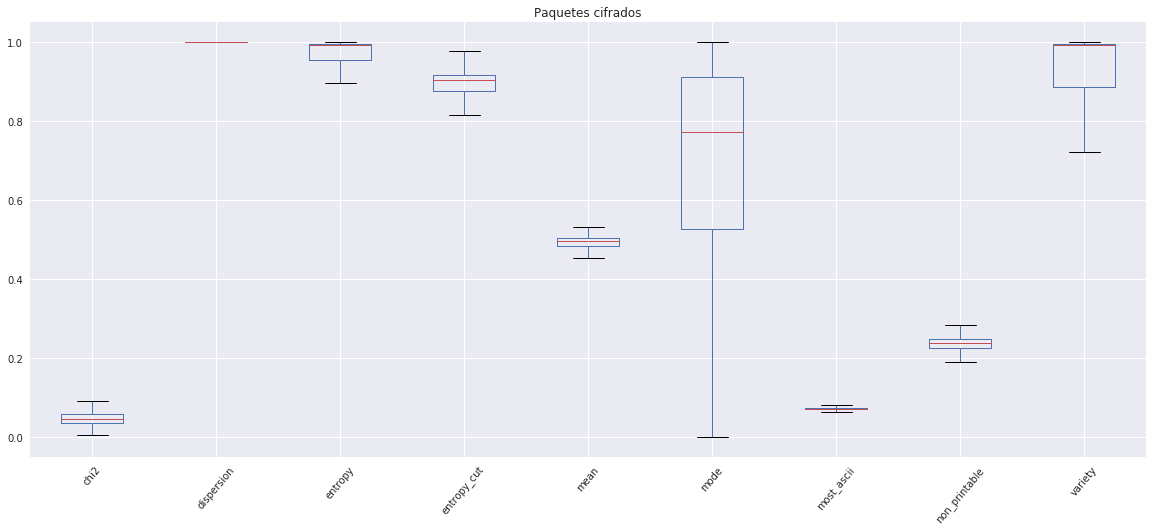

In [146]:
boxplot_encr(X,y)

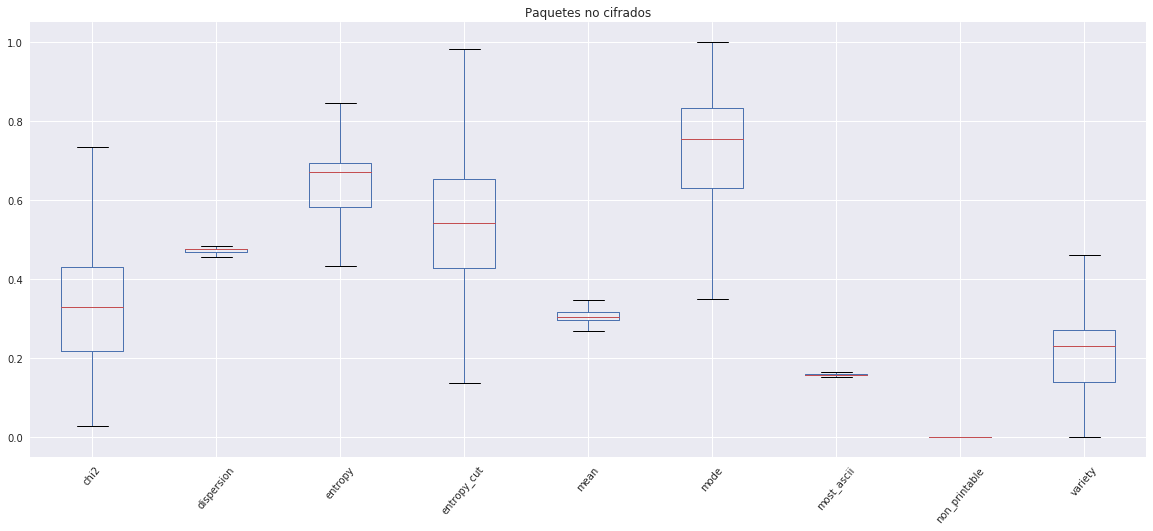

In [147]:
boxplot_non_encr(X,y)

También se observa una separación de las variables en la matriz de scatterplots. En azul están los no cifrados y en verde los cifrados.

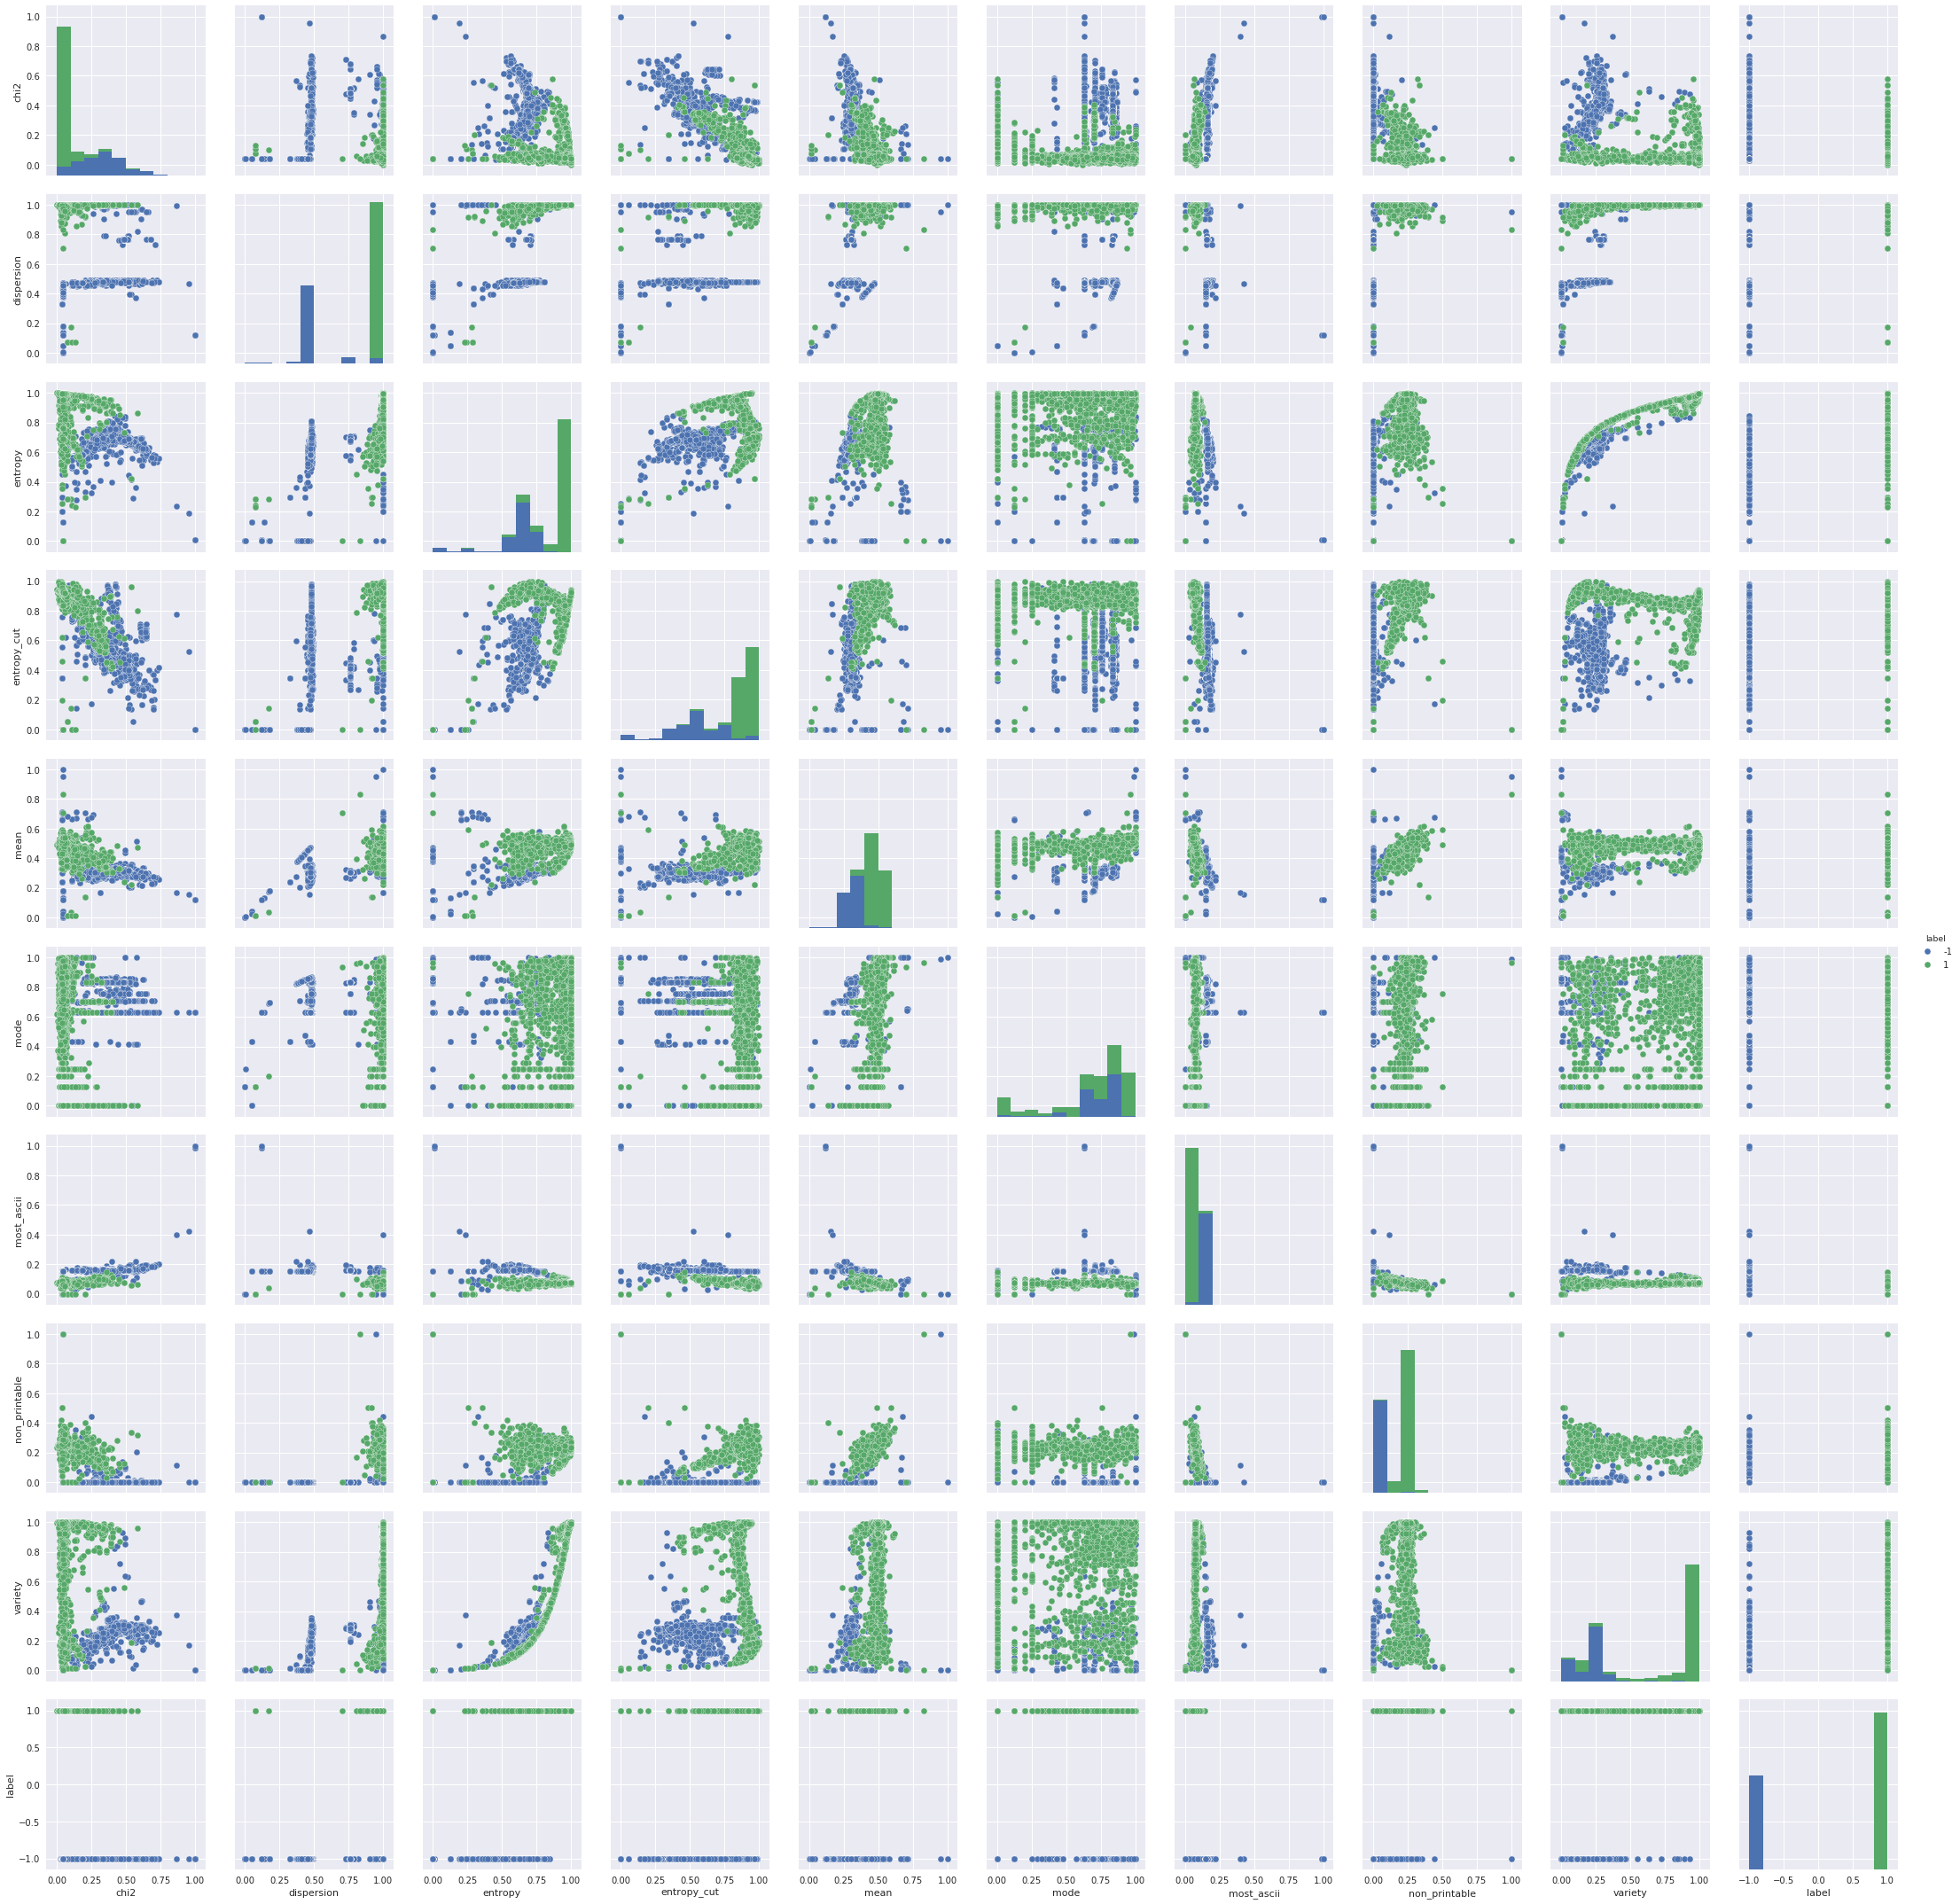

In [151]:
draw_distributions(X,y)

## Descripción pormenorizada

En los paquetes cifrados, se observa que chi2 suele ser bastante bajo. En el caso de los no cifrados, hay una dispersión mayor. Esto se corrobora la hipótesis de que los paquetes cifrados siguen una distribución uniforme.
  

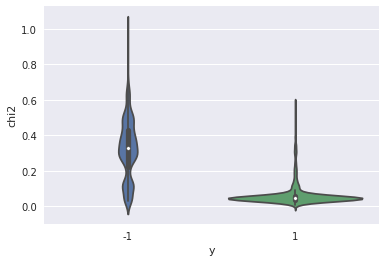

In [152]:
violin_plot(X,y,"chi2")

En los paquetes cifrados, la dispersión suele ser máxima. No sólo se usan los bytes de 0 a 127, sino que hay bytes en 0 y 255. En los no cifrados, sin embargo, suelen estar tener una dispersión dentro de los ASCII imprimibles salvo en caso de que sean ficheros enriquecidos, como los de la suite de Microsoft Office.

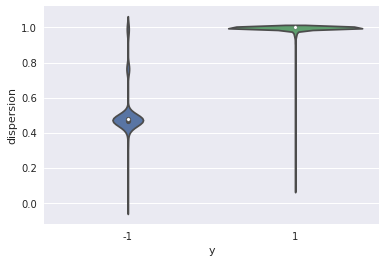

In [153]:
violin_plot(X,y,"dispersion")

La entropía en los paquetes cifrados es muy alta. En los no cifrados es menos alta. 

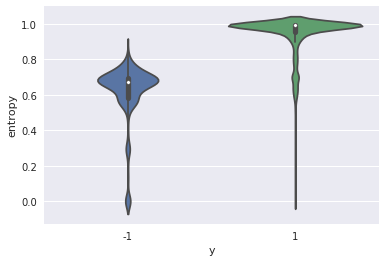

In [154]:
violin_plot(X,y,"entropy")

La variable entropy_cut diferencia más los paquetes cifrados de los que no lo están porque algunos cifrados veían su entropía mermada por la cabecera de los protocolos de la capa 7, que Scapy no implementa en algunos casos. 

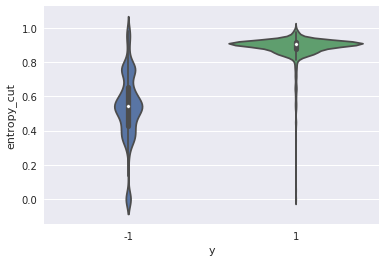

In [155]:
violin_plot(X,y,"entropy_cut")

La media está centrada en el caso de los paquetes cifrados. Esto sucede en las distribuciones uniformes, por lo que es una buena señal.

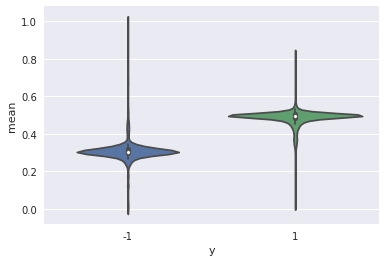

In [156]:
violin_plot(X,y,"mean")

La moda tiene una mayor concentración en valores altos en los paquetes no cifrados. Pese a no mostrar una diferencia abismal en este plot, ésta aporta una buena separación cuando se compara con otras variables como la dispersión. 

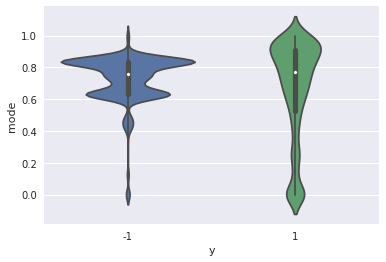

In [157]:
violin_plot(X,y,"mode")

La variable most_ascii representa la proporción de caracteres ASCII imprimibles con respecto al resto de bytes que contiene el payload del paquete. En los cifrados, suele ser muy baja y más alta en los no cifrados.

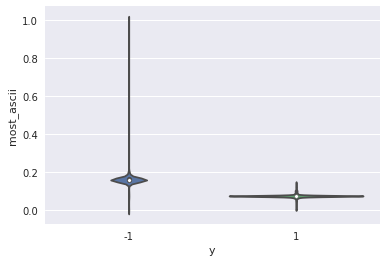

In [158]:
violin_plot(X,y,"most_ascii")

Los cifrados contienen un ratio mayor de de bytes no imprimibles que los no cifrados.

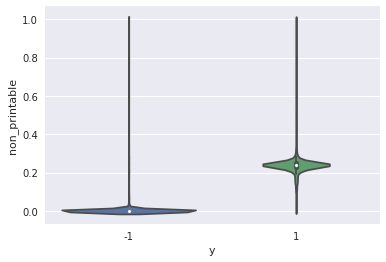

In [159]:
violin_plot(X,y,"non_printable")

La variedad del payload de un paquete es la cuenta de los bytes únicos que hay. 

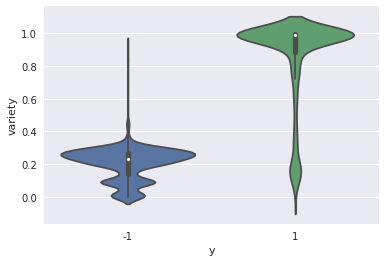

In [160]:
violin_plot(X,y,"variety")

# Entrenamiento del modelo 
Una vez que se han estudiado las variables, se utiliza Naive Bayes como algoritmo de clasificación. El modelo entrenado se guarda para su posterior uso. 

## Naive Bayes

Se trata de un clasificador probabilístico fundamentado en el teorema de Bayes y algunas hipótesis simplificadoras adicionales. Los parámetros utilizados para entrenar este clasificador son las características de las distribuciones del conjunto de entrenamiento.

En el notebook de *Clasificación de sesiones de red* se puede ver cómo se aplica el modelo a cada paquete, y se resume el resultado por sesión. 



In [ ]:
train_model_gnb(X,y)